# Question 6

This script implements both a vanilla DFT and a 15-point Cooley-Tukey FFT from scratch and compares their performance.

In [1]:
from pathlib import Path

import numpy as np
import scipy.fft as fft

import matplotlib.pyplot as plt
import seaborn as sns

from a3_config import A3_ROOT, SAVEFIG_CONFIG

### Construct Signal

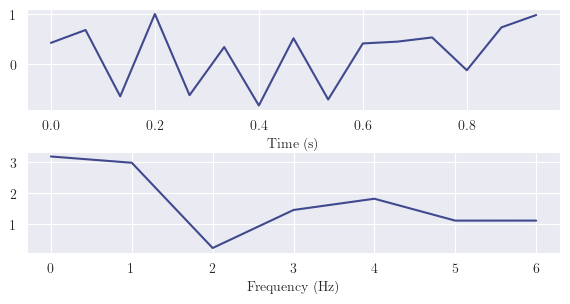

In [2]:
import random; random.seed(24)

x_signal = np.array([2 * (random.random() - 0.5) for _ in range(15)])
h_signal = fft.fft(x_signal)[:7]

t_signal = np.arange(0, 1, 1/15)
f_signal = fft.fftfreq(15, 1/15)[:7]

# Plot signal and its DFT
fig, axs = plt.subplots(2, figsize=(6, 3))
fig.tight_layout()

sns.lineplot(x=t_signal, y=x_signal, ax=axs[0])
sns.lineplot(x=f_signal, y=np.abs(h_signal), ax=axs[1])

axs[0].set_xlabel("Time (s)")
axs[1].set_xlabel("Frequency (Hz)")

# fname = Path(A3_ROOT, "output", "q6_signal.png")
# fig.savefig(fname, **SAVEFIG_CONFIG)
plt.show()

In [3]:
# Export the signal for Question 7
fname = Path(A3_ROOT, "output", "q6_signal_out.npy")
np.save(fname, x_signal)

### Vanilla DFT

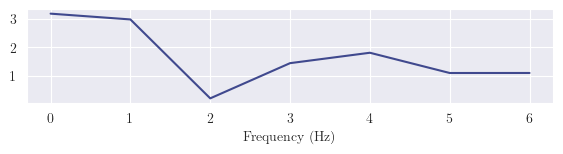

In [4]:
from typing import Any

def dft(x: Any, n: Any = None) -> Any:
    """Compute the 1-D discrete Fourier transform."""
    n = n or len(x)
    X = lambda k: sum(x[i] * np.exp(-2 * np.pi * 1j * i * k / n) for i in range(n))
    return np.array([X(k) for k in range(n)])

h_signal = dft(x_signal)[:7]

# Plot signal and its DFT
fig, ax = plt.subplots(figsize=(6, 1.5))
fig.tight_layout()

sns.lineplot(x=f_signal, y=np.abs(h_signal), ax=ax)
ax.set_xlabel("Frequency (Hz)")

# fname = Path(A3_ROOT, "output", "q6_dft.png")
# fig.savefig(fname, **SAVEFIG_CONFIG)
plt.show()

### Cooley-Tukey FFT

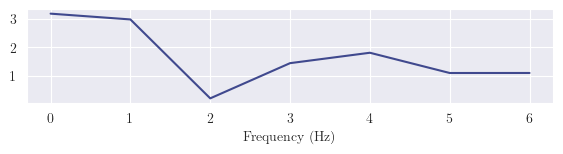

In [5]:
def cooley_tukey(x: Any, radix: int = 3) -> Any:
    """Compute the 1-D discrete Fourier transform using the Cooley-Tukey FFT."""
    if (n := len(x)) % radix != 0:
        raise ValueError(f'input length must be multiple of radix')
    n_rows = radix
    n_cols = int(n / radix)
    # Define DFT operation
    X = lambda x, k, n: sum(x[i] * np.exp(-2 * np.pi * 1j * i * k / n) for i in range(n))
    # Reshape into matrix in row-major order
    x = x.reshape(radix, n_cols)
    # Transform columns
    x = np.array([[X(x[:, j], k, n_rows) for k in range(n_rows)] for j in range(n_cols)]).T
    # Apply twiddle factors
    for j in range(n_cols):
        for i in range(n_rows):
            x[i, j] *= np.exp(-1j * 2 * np.pi * i * j / n)
    # Transform rows
    x = np.array([[X(x[i, :], k, n_cols) for k in range(n_cols)] for i in range(n_rows)])
    # Reshape back into vector in column-major order
    return x.T.reshape(n)

h_signal = cooley_tukey(x_signal, radix=3)[:7]

# Plot signal and its DFT
fig, ax = plt.subplots(figsize=(6, 1.5))
fig.tight_layout()

sns.lineplot(x=f_signal, y=np.abs(h_signal), ax=ax)
ax.set_xlabel("Frequency (Hz)")

# fname = Path(A3_ROOT, "output", "q6_cooley_tukey.png")
# fig.savefig(fname, **SAVEFIG_CONFIG)
plt.show()

### Performance Comparison

In [6]:
import time
from tqdm import trange

N_TRIALS = 10000

time_start = time.time()
for _ in trange(N_TRIALS):
    h_signal = dft(x_signal)

time_elapsed = time.time() - time_start
print(f'DFT ({N_TRIALS} trials): {time_elapsed * 1000 / N_TRIALS:.5f} ms')

time_start = time.time()
for _ in trange(N_TRIALS):
    h_signal = cooley_tukey(x_signal, radix=3)

time_elapsed = time.time() - time_start
print(f'Cooley-Tukey FFT ({N_TRIALS} trials): {time_elapsed * 1000 / N_TRIALS:.5f} ms')


100%|██████████| 10000/10000 [00:03<00:00, 2737.93it/s]


DFT (10000 trials): 0.36651 ms


100%|██████████| 10000/10000 [00:02<00:00, 4147.32it/s]

Cooley-Tukey FFT (10000 trials): 0.24112 ms
